In [1]:
import _init_lib_path

from datetime import datetime
import datetime as dt
import time

from utils.config import cfg
from epoch_loop import EpochLoop

import argparse
from utils.config_file_handling import cfg_from_file, cfg_from_list
from pprint import PrettyPrinter

pp = PrettyPrinter(indent=4)
cfg.TRAINING = True
import torch
torch.set_num_threads(32)

In [2]:
def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Training the network')

    parser.add_argument('-d', '--dataset-dir', dest='dataset_dir',
                        help='dataset directory', type=str, required=False)
    parser.add_argument('-e', '--experiment-dir', dest='experiment_dir',
                        help='a directory used to write experiment results', type=str, required=False)
    parser.add_argument('-u', '--use-gpu', dest='use_gpu',
                        help='whether to use gpu for the net inference', type=int, required=False)
    parser.add_argument('-g', '--gpu-id', dest='gpu_id',
                        help='gpu id to use', type=int, required=False)
    parser.add_argument('-c', '--cfg', dest='cfg_file',
                        help='optional config file to override the defaults', default=None, type=str)
    parser.add_argument('-s', '--set', dest='set_cfg',
                        help='set config arg parameters', default=None, nargs=argparse.REMAINDER)
    return parser.parse_args([])


def set_positional_cfg(args_in):
    args_list = []
    for n, a in args_in.__dict__.items():
        if a is not None and n not in ['cfg_file', 'set_cfg']:
            args_list += [n, a]
    return args_list

args = parse_args()

# print('Called with args:')
# print(args)

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfg is not None:
    cfg_from_list(args.set_cfg)

cfg_from_list(set_positional_cfg(args))     # input arguments override cfg files and defaults

# print('configuration file cfg is loaded for training ...')
# pp.pprint(cfg)

epoch_loop = EpochLoop()
started_time = time.time()


In [3]:
epoch_loop.create_sets()
epoch_loop.setup_net()

creating training sets...
creating validation sets...
setup nets...
creating load
setting up optimizer...


In [4]:
epoch_loop.net.spatial_stream.load_state_dict(torch.load("../experiment/snapshot_UCF101_resnet/20200517_074837_564165/spt_099.pth"))
epoch_loop.net.temporal_stream.load_state_dict(torch.load("../experiment/snapshot_UCF101_resnet/20200517_074837_564165/tmp_099.pth"))

In [5]:
from tqdm.notebook import trange, tqdm
epoch_loop.validator.set_net_mode(epoch_loop.net)

epoch_loop.validator.reset_meters()
prediction_labels = []
gt_labels = []

for i, (image, flow, annotation) in enumerate(tqdm(epoch_loop.validator.data_container.dataloader)):
    image = image.to(epoch_loop.validator.device)
    flow = flow.to(epoch_loop.validator.device)
    with torch.no_grad():
        p = epoch_loop.net.forward(image, flow)
    if p[1] is None:
        p = p[0]
    else:
        p = torch.stack(p).mean(dim=0)
    pred_label = p.argmax(dim=1)
    prediction_labels += list(pred_label.cpu().numpy())
    
    ## gt
    a = epoch_loop.validator.generate_gt(annotation)
    gt_labels += list(a.cpu().numpy())

In [7]:
import numpy as np
prediction_labels = np.array(prediction_labels)
gt_labels = np.array(gt_labels)
np.save('pred.npy', prediction_labels)
np.save('gt.npy', gt_labels)

In [8]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(gt_labels, prediction_labels)

<IPython.core.display.Javascript object>


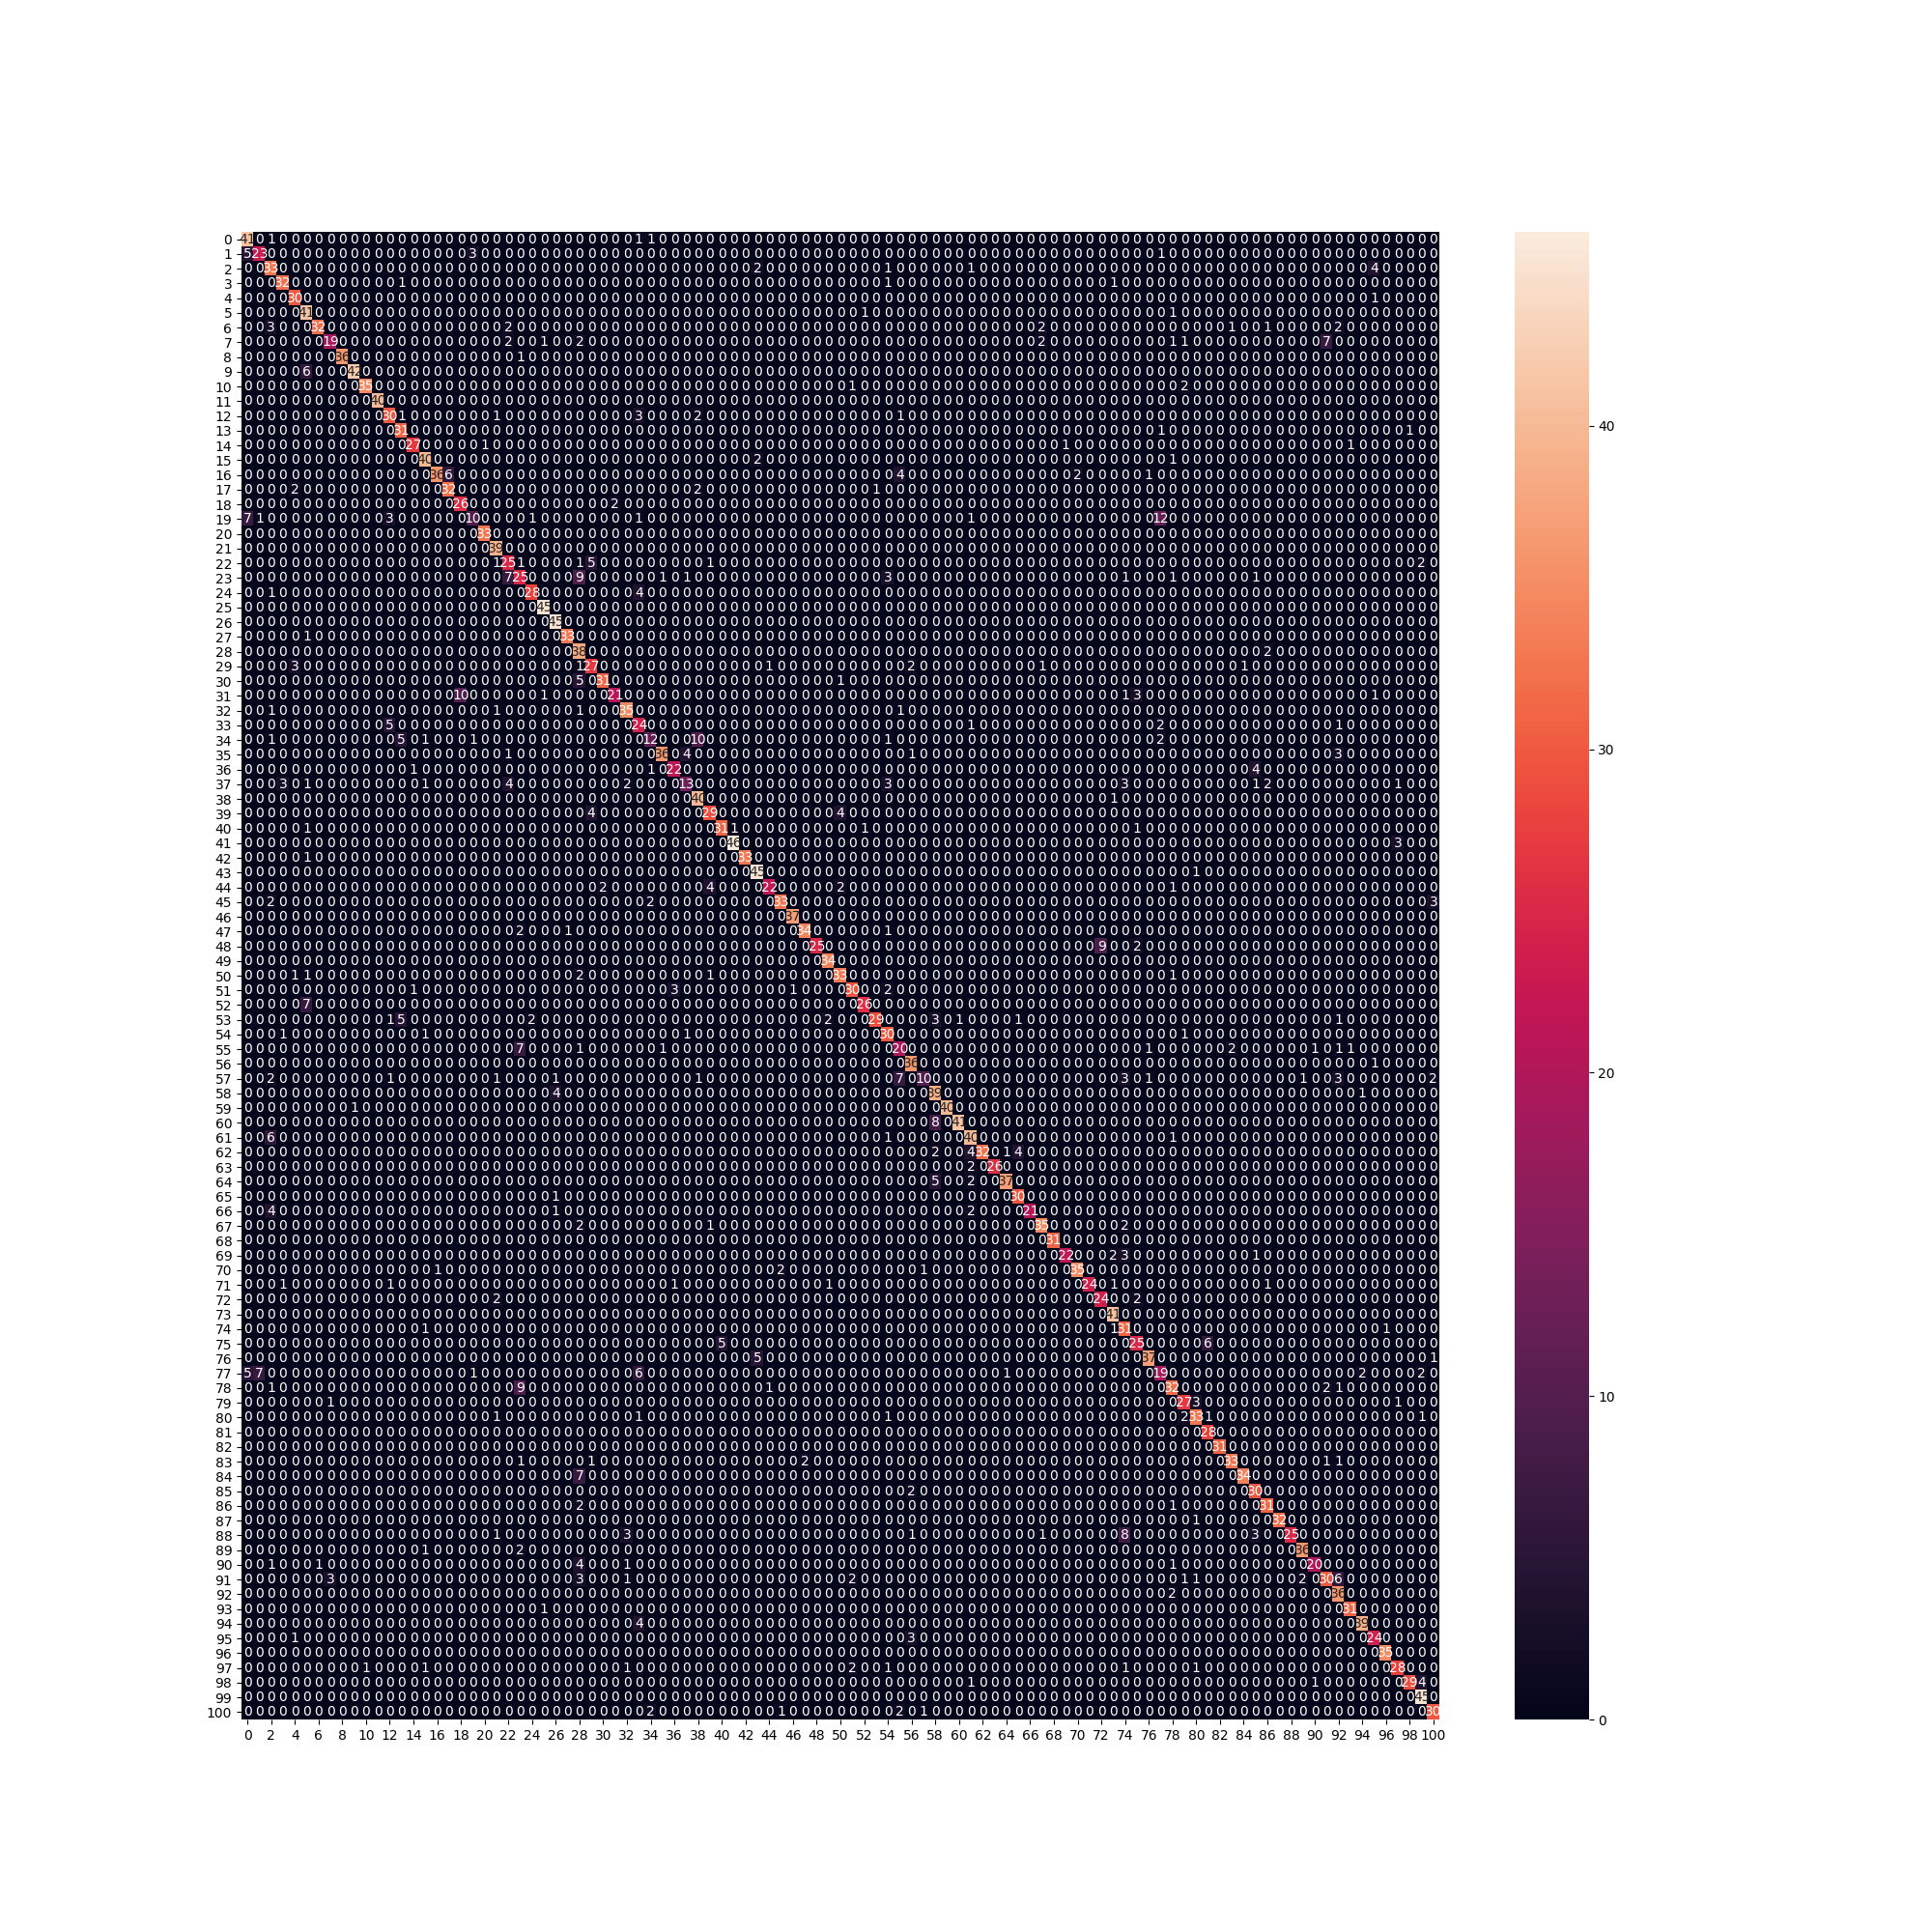

In [9]:
%matplotlib notebook
# !pip install seaborn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = [i for i in range(101)],
                  columns = [i for i in range(101)])
plt.figure(figsize = (20, 20))
sn.heatmap(df_cm, annot=True)

In [11]:
np.mean(prediction_labels == gt_labels)

0.8309076475258005

In [14]:
correct = np.zeros(101)
total = np.zeros(101)
for i in range(len(prediction_labels)):
    total[gt_labels[i]] += 1
    if prediction_labels[i] == gt_labels[i]:
        correct[gt_labels[i]] += 1
acc = correct / total

In [15]:
acc

array([0.93181818, 0.71875   , 0.80487805, 0.91428571, 0.96774194,
       0.95348837, 0.74418605, 0.54285714, 0.97297297, 0.875     ,
       0.92105263, 1.        , 0.78947368, 0.93939394, 0.9       ,
       0.93023256, 0.73469388, 0.86486486, 0.92857143, 0.27777778,
       1.        , 1.        , 0.69444444, 0.51020408, 0.84848485,
       1.        , 1.        , 0.97058824, 0.95      , 0.75      ,
       0.83783784, 0.56756757, 0.8974359 , 0.72727273, 0.36363636,
       0.8       , 0.78571429, 0.38235294, 0.97560976, 0.78378378,
       0.88571429, 0.93877551, 0.97058824, 0.97826087, 0.70967742,
       0.825     , 1.        , 0.89473684, 0.69444444, 1.        ,
       0.84615385, 0.81081081, 0.78787879, 0.64444444, 0.88235294,
       0.57142857, 0.97297297, 0.3030303 , 0.88636364, 0.97560976,
       0.83673469, 0.83333333, 0.74418605, 0.92857143, 0.84090909,
       0.96774194, 0.75      , 0.875     , 1.        , 0.78571429,
       0.8974359 , 0.8       , 0.85714286, 1.        , 0.91176